In [1]:
# autoreload magic
%load_ext autoreload
%autoreload 2

In [5]:
from mldec.datasets import toric_code_data
from mldec.models import baselines
from mldec.utils import evaluation
import numpy as np
config = {'p': 0.05, 'var': 0.03, 'beta': 1}
p_samp = toric_code_data.make_variance_noise_model(9, config, return_probs=True)
display(p_samp)

# p = config.get('p')
# # alpha = config.get('alpha')
# var = config.get('var')
# np.random.seed(222) # just for reproducibility
# p_samp = np.random.normal(p, var, size=n)
# print(p_samp)

# config = {'p': 0.1, 'var': 0.03}
# # config = {'p': 0.06, 'var': 0.02}
# n = 9
# X, Y, weights = toric_code_data.create_dataset_training(n, config, cache=True)
# # X, Y, weights = toric_code_data.uniform_over_good_examples(n, config, cache=True)
# minimum_weight_decoder = baselines.MinimumWeightPerfectMatching()
# minimum_weight_decoder.make_decoder(X, Y)
# preds = minimum_weight_decoder.predict(X).numpy()
# minimum_weight_val_acc = evaluation.weighted_accuracy(minimum_weight_decoder, X, Y, weights)
# print(f"Minimum weight decoder validation accuracy: {minimum_weight_val_acc}")

# X, Y, weightsb, hist = toric_code_data.sample_virtual_XY(weights, 1000, n, config, cache=True)
# print(X.shape, Y.shape, weightsb.shape, hist.shape)

array([0.10890275, 0.05827309, 0.06375975, 0.08003794, 0.02708494,
       0.07165783, 0.02283591, 0.0800562 , 0.03437773])

In [6]:

import numpy as np
import stim
from mldec.codes import toric_code

x_generators, z_generators, Hx, Hz = toric_code.rotated_surface_code_stabilizers(3)
generators = x_generators + z_generators
t = stim.Tableau.from_stabilizers(generators, allow_redundant=True, allow_underconstrained=True)
# we leave out the final stabilizer that canonically represents the degree of 
# freedom for a state we didn't specify
generators_S = [t.z_output(k) for k in range(len(t) - 1)] # stabilizer generators, ordered X type then Z type
generators_T = [t.x_output(k) for k in range(len(t) - 1)] # pure error generators, arbitrary order
generators_L = toric_code.rotated_toric_code_logicals(3) # logicals, ordered X type then Z type


In [ ]:

def build_lst_lookup_and_mle(generators_S, generators_T, generators_L, Hx, Hz, noise_model):
    """Starting from STL, create a lookup table mapping an error to a (syndrome, ell) pair.

    Note: The S,L generators are expected to be [logical_xs, logical_zs] 
    errors in returned hash are binary symplectic form

    Conventions:
     - sigma_z means syndromes for z-stabilizer violations

    TIE-BREAKING: If there are multiple cosets with the same probability, there is no consistent
    way to break ties so that MWPM matches MLE in the iid situation. So, we will return
    the set of all cosets that are tied for the most likely. This means the mle_lookup will
    be ragged, and should be handled carefully.


    Args:
        generators_S: list of generators of the stabilizer group
        generators_T: list of pure errors
        generators_L: list of logical Pauli operators
        Hx, Hz: PCMs for the x- and z-stabilizers
    
    Returns: This is a two-for-one function, returning both the LST lookup table and the MLE lookup table
        lst: a dictionary mapping errors to (syndrome, ell) pairs
            {(error_x, error_z): (np.array([syndrome_x, syndrome_z]), np.array([logical_x, logical_z]))}
                error_x: shape n
                syndrome_x: shape r
                logical_x: shape k
            where syndrome_x is the syndrome for x-stabilizers (in order)
            logical_x is a bitmask for logical operators in logical_x
        mle: a dictionary mapping syndromes to the set of most likely logical _errors_
            {(syndrome_x, syndrome_z): [np.array([logical_x, logical_z]), ...]}
    
    """

    # about 6 seconds

    r = len(generators)
    n = len(generators[0])
    k = n - r
    assert len(generators_L) == 2*k
    assert len(generators_T) == r
    lst = {}
    mle = {}
    err_prs = {}
    mle_acc = 0

    for a, pure_error_lst in enumerate(powerset(generators_T)):
        pure_error = operator_sequence_to_stim(pure_error_lst, n)
        xerr, zerr = pure_error.to_numpy()
        if len(xerr) == 0 and len(zerr) == 0:
            xerr = np.zeros(n, dtype=int)
            zerr = np.zeros(n, dtype=int)
        sigma_z = (Hz @ xerr) % 2
        sigma_x = (Hx @ zerr) % 2
        sigma = np.concatenate((sigma_x, sigma_z), axis=0)
        # we will fill up logical_probs with corresponding total probabilities, then pick the biggest
        # the logical masks are [logical_x, logical_z] bitmasks
        logical_probs = np.zeros(4**k)
        logical_masks = np.array(list(itertools.product([0, 1], repeat=2*k)))
        for b, logical_mask in enumerate(logical_masks):
            # to enumerate over the logicals, we want to preserve their order 
            # as provided in generators_L, as this will determine the binary
            # mask representing that logical
            logical_op_lst = [generators_L[i] for i, bit in enumerate(logical_mask) if bit]
            logical_op = operator_sequence_to_stim(logical_op_lst, n)
            for c, stabilizer_lst in enumerate(powerset(generators_S)):
                stabilizer = operator_sequence_to_stim(stabilizer_lst, n)
                error = pure_error * logical_op * stabilizer
                error_symplectic = np.concatenate(error.to_numpy(), axis=0).astype(int)
                p_err = noise_model(n, error_symplectic)
                err_key = tuple(error_symplectic)
                err_prs[err_key] = p_err
                lst[err_key] = (sigma, np.array(logical_mask))
                logical_probs[b] += p_err
        # no tiebreak, just return everything that is consistent.
        best = logical_probs.max()
        mle_acc += best
        rtol = 1e-6
        winners = np.nonzero(np.isclose(logical_probs, best, rtol=rtol))[0]
        mle[tuple(sigma)] = logical_masks[winners]


    return lst, mle, mle_acc, err_prs



In [36]:
L = 3
n = 9
# noise = 'depol'
noise = 'variance'
if noise == 'depol':
    noise_config = {'p': 0.1}
    noise_model = make_depol_noise_model(n, noise_config)
elif noise == 'variance':
    noise_config = {'p': 0.05, 'var': 0.03, 'beta': 1}
    # noise_config = {'p': 0.2, 'var': 0.05}
    noise_model = toric_code_data.make_variance_noise_model(9, config, return_probs=False)

# build a lookup table for LST in the toric code. This is noise-model-independent
lst = toric_code.build_lst_lookup(L, cache=True)


In [37]:
# I forgot why i needed this and its kind of complicated.
p_SL, hist_SL_wts = toric_code.build_syndrome_probs_and_weight_distr(generators_S, generators_T, generators_L, Hx, Hz, noise_model)

### V&V

A few sanity checks for v/v:
 - We know MWPM should be MLD for iid noise with _uncorrelated_ X- and Z- errors (not the same as "independent" in iid!). So I verified that there are no important errors for a bitflip-only model, i.e. MWPM is MLD in that case.
 

In [39]:
import itertools 
from mldec.models.baselines import MinimumWeightPerfectMatching

# compute mwpm for this dataset

# compute mld for this dataset
X, Y, good_weights = toric_code_data.uniform_over_good_examples(n, noise_config)
X, Y, val_weights = toric_code_data.create_dataset_training(n, noise_config)
mld = baselines.LookupTable()
mld.train_on_histogram(X, Y, good_weights)
mle_lookup = mld.table
mwpm = MinimumWeightPerfectMatching(3)
mwpm.make_decoder(X, Y)
mwpm_lookup = mwpm.lookup

n = L**2
weights = np.arange(0, n+1)
unimportant_prs = np.zeros(n+1)
bad_prs = np.zeros(n+1)
important_prs = np.zeros(n+1)

for syndrome in itertools.product([0, 1], repeat=n-1):
    logical_mles = mld.predict(np.array(syndrome).reshape(1,-1)).numpy()
    logical_mwpm = mwpm.predict(np.array(syndrome).reshape(1,-1)).numpy()
    syndrome_not_counted = True

    for logical in itertools.product([0,1], repeat=2):
        logical = tuple(logical)
        f0_is_correct = not (logical_mwpm ^ logical).sum() 
        fstar_is_correct = any(np.equal(logical_mles, logical).all(1)) 
        f0_in_fstar = any(np.equal(logical_mles, logical_mwpm).all(1))
        p_sigma_logical = p_SL[(syndrome, logical)]

        # for each of the errors in the enumerator, we update
        # the corresponding distribution (important, unimportant, bad)
        # with the probability of this error, at the error's weight
        wt_distr = hist_SL_wts[(syndrome, logical)]
    
        if fstar_is_correct and syndrome_not_counted:
            # we only count one syndrome as the answer to MLE
            syndrome_not_counted = False
            # TODO: need a scheme for weight enumeration here.
            if not f0_is_correct:
                important_prs += wt_distr
            else:
                unimportant_prs += wt_distr
        else:
            bad_prs += wt_distr

print(unimportant_prs)
print(important_prs)
print(bad_prs)
# compute the sum of all 3
print(sum(unimportant_prs) + sum(important_prs) + sum(bad_prs))

[5.66664991e-01 3.34454924e-01 4.28065629e-02 2.40283149e-03
 1.53260377e-04 8.10289364e-06 2.81190486e-07 7.72205954e-09
 1.09315601e-10 4.44543087e-13]
[0.00000000e+00 0.00000000e+00 1.55102874e-02 1.55013129e-03
 1.32204167e-04 7.28888992e-06 2.72152716e-07 6.71911537e-09
 8.45631387e-11 3.78112495e-13]
[0.00000000e+00 0.00000000e+00 2.70409360e-02 8.39016252e-03
 8.26659821e-04 4.91907575e-05 1.85709757e-06 4.11662196e-08
 5.24160164e-10 3.12765665e-12]
1.0


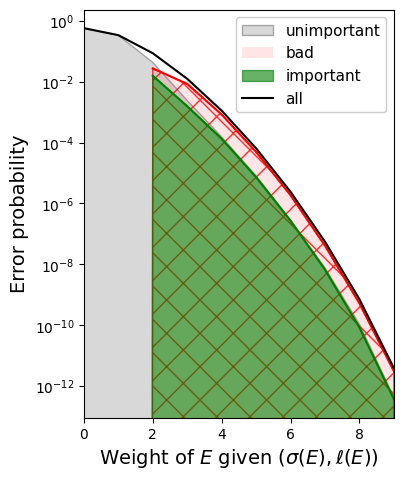

In [48]:
import matplotlib.pyplot as plt
# cm = 1/2.54
fig, ax = plt.subplots(1, 1, figsize=(4, 5.3), constrained_layout = False)
#matplotlib rendering bug https://stackoverflow.com/questions/5195466/matplotlib-does-not-display-hatching-when-rendering-to-pdf

zero = min(bad_prs)

ax.fill_between(weights, important_prs, unimportant_prs, label='unimportant', facecolor="grey", edgecolor='k', alpha=0.3)
# ax.plot(weights, unimportant_prs, label='unimportant', c='k', alpha=1)
ax.fill_between(weights, np.ones_like(bad_prs) * zero, bad_prs, label='bad', facecolor="r",  alpha=0.1)
ax.plot(weights[bad_prs>0], bad_prs[bad_prs>0], alpha=1, c='r') # bold line
ax.fill_between(weights, np.ones_like(bad_prs) * zero, bad_prs, facecolor='none', hatch="x", edgecolor='r', alpha=.8)  #hatching nonalpha

ax.fill_between(weights, np.ones_like(important_prs) * zero, important_prs, label='important', facecolor='g', edgecolor='g', alpha=0.6, )
ax.plot(weights[important_prs>0], important_prs[important_prs>0], c='g', alpha=1 )
# ax.fill_between(weights, np.ones_like(important_prs) * zero, important_prs, label='important',  facecolor="none",  hatch='|', edgecolor='g', alpha=.8, )
all = unimportant_prs + important_prs + bad_prs
ax.plot(weights, all, label='all', c='k', alpha=1)

ax.set_xlim(0, n)
labelsz = 14
ax.set_xlabel(r"Weight of $E$ given $(\sigma(E), \ell(E))$", fontsize=labelsz)
ax.set_ylabel(r"Error probability", fontsize=labelsz)
ax.semilogy()
ax.legend(prop={'size': 11}, framealpha=1, loc='upper right', bbox_to_anchor=(1.0, 1))


fig.savefig('../../figures/fig2_a.pdf', bbox_inches='tight')
print()

In [245]:
print(unimportant_prs)
print(important_prs)
print(bad_prs)

[7.17657949e-01 2.43093313e-01 1.76467564e-02 6.01221729e-04
 2.33991090e-05 7.51503890e-07 1.60727735e-08 2.75013586e-10
 2.51263719e-12 6.93672939e-15]
[0.00000000e+00 0.00000000e+00 5.90335804e-03 3.27378148e-04
 1.85833974e-05 6.37604652e-07 1.51318462e-08 2.37834664e-10
 1.91931891e-12 5.76148556e-15]
[0.00000000e+00 0.00000000e+00 1.24660333e-02 2.13344531e-03
 1.22622930e-04 4.41379954e-06 1.03009003e-07 1.45223964e-09
 1.21085712e-11 4.83369413e-14]
